In [19]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = table[0]['Symbol'].to_list()
sp500_list = [s.replace('.', '-') for s in sp500_list]
len(sp500_list)

503

In [21]:
table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')
nasdaq_list = table[4]['Ticker'].to_list()
nasdaq_list = [s.replace('.', '-') for s in nasdaq_list]
len(nasdaq_list)

102

In [22]:
table = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
dj_list = table[1]['Symbol'].to_list()
dj_list = [s.replace('.', '-') for s in dj_list]
len(dj_list)

30

In [23]:
stock_pool = list(set(sp500_list).union(set(nasdaq_list)).union(set(dj_list)))
print(len(stock_pool))
# stock_pool = np.random.choice(stock_pool, 50, replace=False)
start, end = '2022-01-01', '2022-10-31'

526


In [24]:
# from main import stocks_norm_return
# norm_return = stocks_norm_return(stock_pool, start, end, dropna=True)
# norm_return.to_csv(f'all_stocks_return_{start}_{end}.csv', index=True)

In [25]:
# spy = yf.download("SPY", start=start, end=end)
# spy.to_csv(f'spy_{start}_{end}.csv', index=True)

In [26]:
norm_return = pd.read_csv(f'all_stocks_return_{start}_{end}.csv', index_col=0)
norm_return.index = pd.to_datetime(norm_return.index)
spy = pd.read_csv(f'spy_{start}_{end}.csv', index_col=0)
spy.index = pd.to_datetime(spy.index)

In [27]:
from main import MC_portfolio

p = MC_portfolio(norm_return, 1e6)
p.mc_stock_choice(iter=20000, k=100, history=True)
p.best_sharpe, p.best_pnl

(-0.1421531760910854, 0.9869000406951501)

In [28]:
hist = {}
for idx in np.argpartition(p.history_sharpe, -100)[-100:]:
    for s in p.history_stocks[idx]:
        if hist.get(s, -1) == -1:
            hist[s] = 1
        else:
            hist[s] += 1
hist_df = pd.DataFrame(hist.items(), columns=['stock', 'freq']).sort_values('freq')

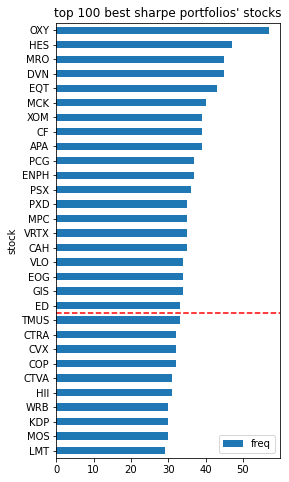

In [29]:
topk, bestk = 30, 20
ax = hist_df.tail(topk).plot.barh(x='stock', figsize=(4,8), title="top 100 best sharpe portfolios' stocks")
ax.axhline(topk-bestk-0.5, c='red', ls='--')

In [30]:
my_best_stocks1 = hist_df.tail(bestk).stock.values
f_weights1 = (hist_df.tail(bestk).freq / hist_df.tail(bestk).freq.sum()).values
p.mc_weight_choice(my_best_stocks1, iter=5000, by='sharpe')
mc_weights1 = p.best_weights

In [31]:
hist = {}
for idx in np.argpartition(p.history_pnl, -100)[-100:]:
    for s in p.history_stocks[idx]:
        if hist.get(s, -1) == -1:
            hist[s] = 1
        else:
            hist[s] += 1
hist_df = pd.DataFrame(hist.items(), columns=['stock', 'freq']).sort_values('freq')

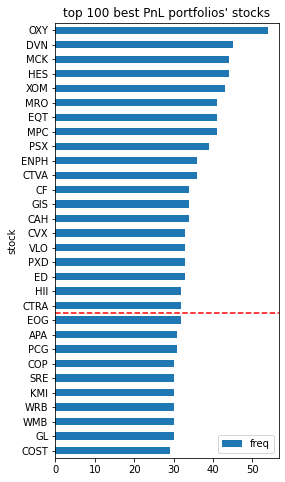

In [32]:
ax = hist_df.tail(topk).plot.barh(x='stock', figsize=(4,8), title="top 100 best PnL portfolios' stocks")
ax.axhline(topk-bestk-0.5, c='red', ls='--')

In [33]:
my_best_stocks2 = hist_df.tail(bestk).stock.values
f_weights2 = (hist_df.tail(bestk).freq / hist_df.tail(bestk).freq.sum()).values
p.mc_weight_choice(my_best_stocks2, iter=5000, by='pnl')
mc_weights2 = p.best_weights

<AxesSubplot:xlabel='Date'>

<Figure size 1152x576 with 0 Axes>

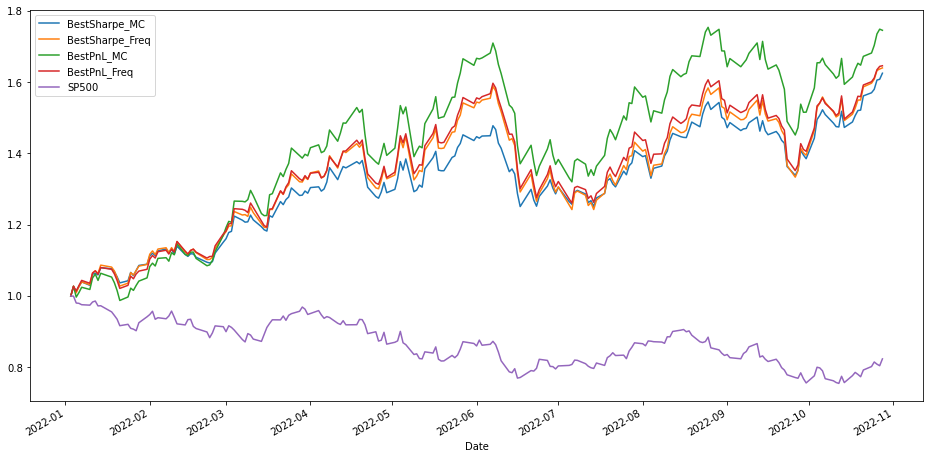

In [34]:
from main import build_portfolio, init_weight_choice
fig = plt.figure(figsize=(16,8))

bsharpe_mc = build_portfolio(norm_return, 1e6, my_best_stocks1 , mc_weights1)
bsharpe_f = build_portfolio(norm_return, 1e6, my_best_stocks1 , f_weights1)

bpnl_mc = build_portfolio(norm_return, 1e6, my_best_stocks2 , mc_weights2)
bpnl_f = build_portfolio(norm_return, 1e6, my_best_stocks2 , f_weights2)

spy_PerPos = spy['Adj Close'] / spy['Adj Close'].iloc[0]

super_df = pd.concat([bsharpe_mc.PercentagePos, bsharpe_f.PercentagePos, bpnl_mc.PercentagePos, bpnl_f.PercentagePos, spy_PerPos], axis=1)
super_df.columns = ['BestSharpe_MC', 'BestSharpe_Freq', 'BestPnL_MC', 'BestPnL_Freq', 'SP500']
super_df.plot(figsize=(16,8))

In [35]:
bsharpe_f.DailyPercentageReturn.min(), bsharpe_mc.DailyPercentageReturn.min(), bpnl_f.DailyPercentageReturn.min(), bpnl_mc.DailyPercentageReturn.min()

(-0.08414114694374597,
 -0.06633797639144268,
 -0.07689998458301162,
 -0.09096132961162551)

In [36]:
bsharpe_f.DailyPercentageReturn.std(), bsharpe_mc.DailyPercentageReturn.std(), bpnl_f.DailyPercentageReturn.std(), bpnl_mc.DailyPercentageReturn.std()

(0.021099200812009857,
 0.01782476087634132,
 0.02020417176205351,
 0.02265985957498123)